# IJCNN

In [1]:
import sys
sys.path.append('/Users/IzmailovPavel/Documents/Education/Course Project/Code')
import numpy as np
import matplotlib as mpl

from matplotlib import pyplot as plt

from GP.covariance_functions import SquaredExponential
from GP.gaussian_process_classification import GPC

from sklearn.cluster import KMeans

from sklearn.datasets import load_svmlight_file
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Данные

In [2]:
x_tr, y_tr = load_svmlight_file('../../../../Programming/DataSets/Classification/ijcnn1(49990,22).txt')
x_tr, y_tr = shuffle(x_tr, y_tr, random_state=241)
x_test, y_test = load_svmlight_file('../../../../Programming/DataSets/Classification/ijcnn1_test(91701,22).txt')
x_test, y_test = shuffle(x_test, y_test, random_state=230)
x_test = x_test[:8000, :]
y_test = y_test[:8000]
data_name = 'ijcnn'

x_tr = x_tr.toarray()
x_test = x_test.toarray()
scaler = StandardScaler()
x_tr = scaler.fit_transform(x_tr).T
x_test = scaler.transform(x_test).T

x_tr = (x_tr + 1) / 2
x_test = (x_test + 1) / 2
y_tr = y_tr[:, None]
y_test = y_test[:, None]
y_tr[y_tr == 0] = -1
y_test[y_test == 0] = -1
dim, num = x_tr.shape

print('of objects:', num)
print('of features:', dim)
print(data_name)

of objects: 35000
of features: 22
ijcnn


## K-Means cluster centers

In [3]:
ind_num = 500
print('Finding means...')
means = KMeans(n_clusters=ind_num, n_init=3, max_iter=100, random_state=241)
means.fit(x_tr.T)
inputs = means.cluster_centers_.T
print('...found')

Finding means...
...found


In [16]:
cov_params = np.array([1., 1., .1])

## svi-L-BFGS-B-c method

In [33]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
svi_gp = GPC(model_covariance_obj, method='svi')

In [ ]:
opts = {'mode': 'full', 'maxiter': 100, 'mydisp': True}
svi_res = svi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Hyper-parameters at iteration 0 : [ 10.   20.    0.1   0.    0. ]
Hyper-parameters at iteration 1 : [  1.00012780e+01   1.99962267e+01   5.21819681e-01  -1.94654840e-02
  -1.16229340e-01]
Hyper-parameters at iteration 2 : [  9.97990063  19.99353314   0.26460446  -0.16966981  -0.80989622]
Hyper-parameters at iteration 3 : [  9.97719232  19.98869996   0.17598408  -0.24182403  -1.10739343]
Hyper-parameters at iteration 4 : [  9.97600085  19.98146191   0.18842116  -0.33011074  -1.46743958]
Hyper-parameters at iteration 5 : [  9.97489348  19.96836291   0.25521643  -0.50467553  -2.017685  ]
Hyper-parameters at iteration

In [28]:
metric = lambda w: svi_gp.get_prediction_quality(w, x_test, y_test)
svi_x_lst, svi_y_lst = svi_res.plot_performance(metric, 't', freq=1)

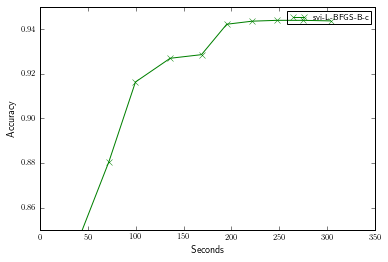

In [29]:
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.85, .95])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## vi-means-c method


In [11]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'maxfun':5, 'mydisp': True, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=10)

Hyper-parameters at iteration 0 : [ 3.   2.   0.1]
	Hyper-parameters at outter iteration 0 : [ 2.98923493  5.44738271  0.09967597]
Hyper-parameters at iteration 0 : [ 2.98923493  5.44738271  0.09967597]
Hyper-parameters at iteration 1 : [ 23.56298381   5.19512812   0.09551566]
	Hyper-parameters at outter iteration 1 : [  2.67346114e+01   8.18511548e+00   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.67346114e+01   8.18511548e+00   1.00000000e-02]
	Hyper-parameters at outter iteration 2 : [  2.57736252e+01   7.89114774e+00   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.57736252e+01   7.89114774e+00   1.00000000e-02]
	Hyper-parameters at outter iteration 3 : [  2.58344718e+01   9.60381012e+00   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.58344718e+01   9.60381012e+00   1.00000000e-02]
	Hyper-parameters at outter iteration 4 : [  2.59078145e+01   1.04675914e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.59078145e+01   1.04675914e+01   1.00000000

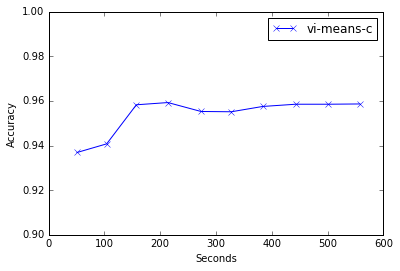

In [12]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_x_lst, vi_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

### Taylor
Подбор числа пересчетов

In [7]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'bound': 'Taylor', 'maxfun':5, 'mydisp': True, 'num_updates':3}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=20)

Hyper-parameters at iteration 0 : [ 10.   20.    0.1]
Hyper-parameters at iteration 1 : [ 15.43672779  15.600007     0.08019013]
Hyper-parameters at iteration 2 : [  1.67454905e+01   1.39006917e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 0 : [  1.50240713e+01   1.54041292e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.50240713e+01   1.54041292e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 1 : [  1.50244020e+01   1.54040148e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.50244020e+01   1.54040148e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 2 : [  1.50253865e+01   1.54037589e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  1.50253865e+01   1.54037589e+01   1.00000000e-02]
Hyper-parameters at iteration 1 : [  2.73620806e+01   1.23041019e+01   1.00000000e-02]
	Hyper-parameters at outter iteration 3 : [  2.73672375e+01   1.23027971e+01   1.00000000e-02]
Hyper-parameters at iteration 0 : [  2.73672375e+01   1.

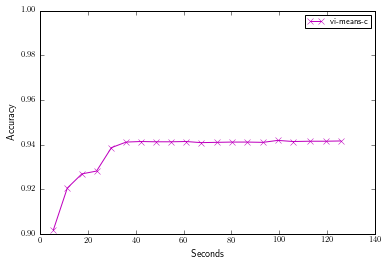

In [8]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_t_x_lst, vi_t_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

### JJ-full

In [21]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi_full')
opts = {'maxiter': 18, 'mydisp': True}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Hyper-parameters at iteration 0 : [ 1.   1.   0.1  1.   1. ]
Hyper-parameters at iteration 1 : [ 0.99900907  1.99993725  0.09990992  1.00005681  1.00004286]
Hyper-parameters at iteration 2 : [ 1.11756693  2.02474222  0.01        1.00006959  1.00005342]
Hyper-parameters at iteration 3 : [ 1.1707368   2.03387484  0.01        1.00007631  1.00005895]
Hyper-parameters at iteration 4 : [ 1.48809796  2.12048545  0.01        1.00015098  1.00012016]
Hyper-parameters at iteration 5 : [ 1.69919773  2.21945918  0.01        1.00024945  1.00020117]
Hyper-parameters at iteration 6 : [ 2.05811791  2.43423554  0.01        1.00056212  1.00046084]
Hyper-parameters at iteration 7 : [ 2.52731028  2.74433231  0.01        1.00128826  1.00107117]
Hyper-parameters at iteration 8 : [ 3.06977448  3.10097135  0.01        1.00221506  1.00185216]
Hyper-parameters at iteration 9 : [ 3.48193729  3.36130513  0.01        1.00295835  1.00247975]
Hyper-parameters at iteration 10 : [ 3.72493004  3.50367598  0.01        1.

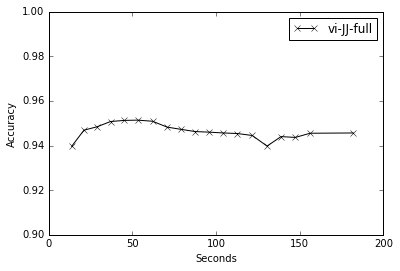

In [22]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_tr, y_tr, x_test, y_test)
vi_full_x_lst, vi_full_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_full_x_lst[1:], vi_full_y_lst[1:], '-kx', label='vi-JJ-full')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([0.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

### Stochastic Taylor

In [14]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
vi_gp = GPC(model_covariance_obj, method='vi')
opts = {'bound': 'Taylor', 'mode': 'adadelta', 'num_updates': 1, 'mydisp': True, 'print_freq': 1, 'step_rate': 1.,
        'maxiter': 1, 'batch_size':1000}
vi_res = vi_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts, max_out_iter=25)

Iteration  1 :
	Gradient norm 28.1776068777
	Hyper-parameters at outter iteration 0 : [ 11.27415051  18.61077423   0.04686753]
Iteration  1 :
	Gradient norm 102.05988787
	Hyper-parameters at outter iteration 1 : [  1.24482182e+01   1.73590466e+01   1.67022205e-02]
Iteration  1 :
	Gradient norm 96.3969687083
	Hyper-parameters at outter iteration 2 : [ 13.50931531  16.24240613  -0.01788846]
Iteration  1 :
	Gradient norm 117.559503794
	Hyper-parameters at outter iteration 3 : [ 14.5802847   15.110978     0.03456205]
Iteration  1 :
	Gradient norm 37.6117229924
	Hyper-parameters at outter iteration 4 : [  1.56479837e+01   1.39916326e+01  -8.08146689e-03]
Iteration  1 :
	Gradient norm 101.497809677
	Hyper-parameters at outter iteration 5 : [  1.66699841e+01   1.29277653e+01   4.53157229e-03]
Iteration  1 :
	Gradient norm 28.2842959414
	Hyper-parameters at outter iteration 6 : [  1.76673174e+01   1.18971580e+01  -4.16344431e-03]
Iteration  1 :
	Gradient norm 12.7585909424
	Hyper-parameters at

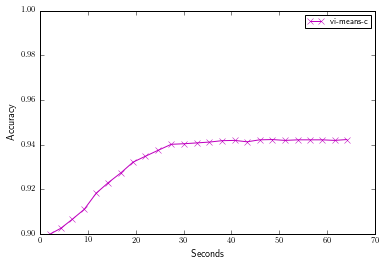

In [15]:
metric = lambda w: vi_gp.get_prediction_quality(w, x_test, y_test)
vi_st_x_lst, vi_st_y_lst = vi_res.plot_performance(metric, 't', freq=1)
plt.plot(vi_st_x_lst[1:], vi_st_y_lst[1:], '-mx', label='vi-means-c')
# plt.plot(svi_x_lst[1:100], svi_y_lst[1:100], '-gx', label='svi-L-BFGS-B-c')
plt.ylim([.9, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [10]:
vi_st_y_lst[15]

0.94174999999999998

## svi-AdaDelta-c
Подбор длины шага

In [20]:
results = []
steps = [1.2, 1.1, 1.]
for step in steps:
    print(step)
    model_covariance_obj = SquaredExponential(np.copy(cov_params))
    ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)

    opts = {'mode': 'adadelta', 'maxiter': 20, 'verbose': False, 'batch_size': 350, 
            'step_rate': step}#, 'print_freq':50}
    batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)
    results.append(batch_res)

1.2
1.1
1.0


/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:614: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


0
1
2


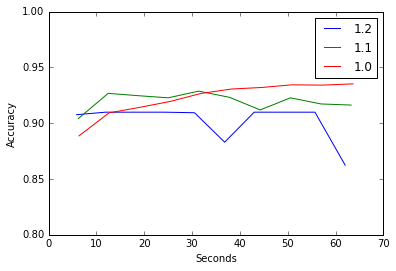

In [21]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
for i in range(len(results)):
    svi_ad_x_lst, svi_ad_y_lst = results[i].plot_performance(metric, 't', freq=1)
    plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], label=steps[i])
    print(i)
plt.ylim([0.8, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [22]:
model_covariance_obj = SquaredExponential(np.copy(cov_params))
ad_gp = GPC(model_covariance_obj, method='svi', hermgauss_deg=100)
opts = {'mode': 'adadelta', 'maxiter': 30, 'verbose': True, 'batch_size': 350, 
        'step_rate': 1., 'print_freq':1}
batch_res = ad_gp.fit(x_tr, y_tr, inputs=inputs, optimizer_options=opts)

Using AdaDelta optimizer
Iteration  1 :
	Gradient norm 8.8346584206
Iteration  2 :
	Gradient norm 7.19278907977
Iteration  3 :
	Gradient norm 13.3856414634
Iteration  4 :
	Gradient norm 7.87188241742
Iteration  5 :
	Gradient norm 8.43101824246
Iteration  6 :
	Gradient norm 19.320388366
Iteration  7 :
	Gradient norm 8.11076290142
Iteration  8 :
	Gradient norm 9.9716405351
Iteration  9 :
	Gradient norm 12.652559551
Iteration  10 :
	Gradient norm 12.7613938602
Iteration  11 :
	Gradient norm 8.5814728066
Iteration  12 :
	Gradient norm 23.599347291
Iteration  13 :
	Gradient norm 7.91119979681
Iteration  14 :
	Gradient norm 8.89976175494
Iteration  15 :
	Gradient norm 12.3944426749
Iteration  16 :
	Gradient norm 7.5457788762
Iteration  17 :
	Gradient norm 8.01256424602
Iteration  18 :
	Gradient norm 13.4304652137
Iteration  19 :
	Gradient norm 7.75074626901
Iteration  20 :
	Gradient norm 6.45421833831
Iteration  21 :
	Gradient norm 12.9885841569
Iteration  22 :
	Gradient norm 8.38827451034
I

/Users/IzmailovPavel/Documents/Education/Course Project/Code/GP/gaussian_process_classification.py:614: RuntimeWarning: invalid value encountered in log
  loss += np.sum(np.log(np.diag(sigma_L))) * l / N


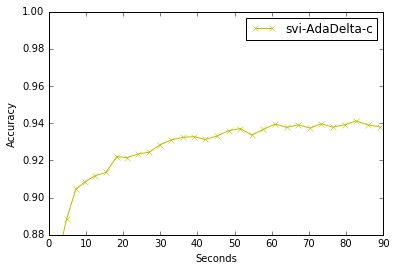

In [23]:
metric = lambda w: ad_gp.get_prediction_quality(w, x_test, y_test)
svi_ad_x_lst, svi_ad_y_lst = batch_res.plot_performance(metric, 't', freq=1)
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.ylim([0.88, 1.])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

## Выводы

In [26]:
# svi_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy')
# svi_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy')
# vi_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy')
# vi_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy')
# vi_t_x_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_x.npy')
# vi_t_y_lst = np.load('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_y.npy')

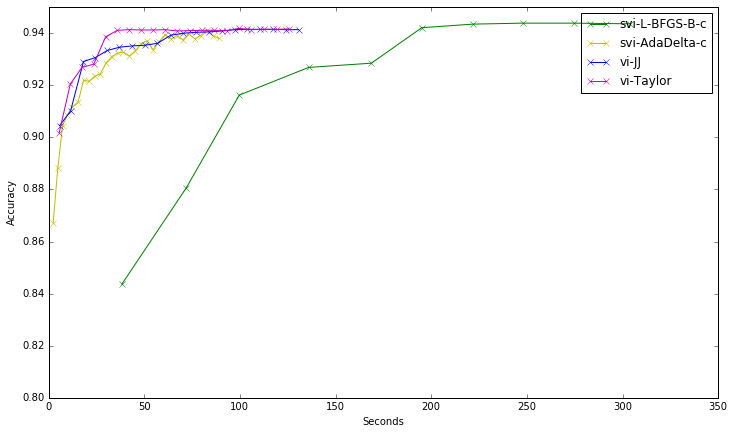

In [30]:
plt.figure(figsize=(12, 7))
plt.plot(svi_x_lst[1:], svi_y_lst[1:], '-gx', label='svi-L-BFGS-B-c')
plt.plot(svi_ad_x_lst[1:], svi_ad_y_lst[1:], '-yx', label='svi-AdaDelta-c')
plt.plot(vi_x_lst[1:], vi_y_lst[1:], '-bx', label='vi-JJ')
plt.plot(vi_t_x_lst[1:], vi_t_y_lst[1:], '-mx', label='vi-Taylor')
plt.ylim([0.8, .95])
plt.legend()
plt.xlabel('Seconds')
plt.ylabel('Accuracy')

In [31]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_x.npy', svi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_svi_y.npy', svi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_x.npy', svi_ad_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_ad_y.npy', svi_ad_y_lst)

In [32]:
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_x.npy', vi_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_y.npy', vi_y_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_x.npy', vi_t_x_lst)
np.save('../plots/vi_vs_svi_class/'+ data_name +'_vi_t_y.npy', vi_t_y_lst)